In [1]:
import numpy as np
import matplotlib.pylab as plt
import healpy as hp
from lsst.sims.featureScheduler.modelObservatory import Model_observatory
from lsst.sims.featureScheduler.schedulers import Core_scheduler
from lsst.sims.featureScheduler.utils import standard_goals, calc_norm_factor
import lsst.sims.featureScheduler.basis_functions as bf
from lsst.sims.featureScheduler.surveys import (generate_dd_surveys, Greedy_survey,
                                                Blob_survey, Pairs_survey_scripted)
from lsst.sims.featureScheduler import sim_runner

from basic_survey import gen_greedy_surveys


import lsst.sims.maf.db as db
import lsst.sims.maf.utils as utils
import lsst.sims.maf.metrics as metrics
import lsst.sims.maf.slicers as slicers
import lsst.sims.maf.stackers as stackers
import lsst.sims.maf.metricBundles as metricBundles

import lsst.sims.maf.plots as plots

In [2]:
# The simple MAF plots to check what happend
def check_run(dbroot):
    bundleList = []
    for filtername in filters:
        metric = metrics.CountMetric(col='observationStartMJD')
        slicer = slicers.HealpixSlicer()
        sql = 'filter = "%s"' % filtername
        bundleList.append(metricBundles.MetricBundle(metric,slicer,sql,runName=dbroot,
                                                     plotFuncs=[plots.HealpixSkyMap()]))

    slicer =  slicer = slicers.HealpixSlicer(nside=64, latCol='altitude', lonCol='azimuth', useCache=False)
    sql=''
    metric = metrics.CountMetric(col='observationStartMJD')
    bundleList.append(metricBundles.MetricBundle(metric,slicer,sql, 
                                                 runName=dbroot, plotFuncs=[plots.LambertSkyMap()]))


    slicer = slicers.HourglassSlicer()
    sql=''
    metric = metrics.HourglassMetric(metricName='Hourglass')
    bundleList.append(metricBundles.MetricBundle(metric,slicer,sql,runName=dbroot))
    conn =  db.OpsimDatabase('%s.db' % dbroot)
    bd = metricBundles.makeBundlesDictFromList(bundleList)
    bg = metricBundles.MetricBundleGroup(bd, conn, outDir=dbroot, resultsDb=None)
    bg.runAll()
    bg.plotAll(closefigs=False)

In [5]:
def run_sim(runName, weights, filters, survey_length=30.):
    nside = 32
    surveys = gen_greedy_surveys(nside, add_DD=False, **weights, filters=filters)
    scheduler = Core_scheduler(surveys, nside=nside)
    observatory = Model_observatory(nside=nside)
    observatory, scheduler, observations = sim_runner(observatory, scheduler,
                                                      survey_length=survey_length,
                                                      filename='%s.db' % runName)
    check_run(runName)

/Users/yoachim/gitRepos/sims_skybrightness_pre/python/lsst/sims/skybrightness_pre/SkyModelPre.py:370: UserWarning: Requested MJD between sunrise and sunset, returning closest maps
  warnings.warn('Requested MJD between sunrise and sunset, returning closest maps')
/Users/yoachim/gitRepos/sims_featureScheduler/python/lsst/sims/featureScheduler/modelObservatory/model_observatory.py:279: RuntimeWarning: invalid value encountered in less
  slewtimes[np.where(slewtimes < 0)] = np.nan
/Users/yoachim/gitRepos/sims_featureScheduler/python/lsst/sims/featureScheduler/modelObservatory/model_observatory.py:441: UserWarning: overriding requested rotSkyPos value
  warnings.warn('overriding requested rotSkyPos value')


progress = 100.1%Skipped 0 observations
Flushed 0 observations from queue for being stale
Completed 24611 observations
ran in 7 min = 0.1 hours


/Users/yoachim/gitRepos/sims_featureScheduler/python/lsst/sims/featureScheduler/sim_runner.py:98: UserWarning: Failed to get info about run, may need to run scons in some pacakges.
  warnings.warn('Failed to get info about run, may need to run scons in some pacakges.')


Healpix slicer using NSIDE=128, approximate resolution 27.483891 arcminutes
Healpix slicer using NSIDE=64, approximate resolution 54.967783 arcminutes
Querying database SummaryAllProps with constraint filter = "r" for columns ['observationStartMJD', 'fieldDec', 'fieldRA']
Found 24611 visits
Running:  ['default_Count_observationStartMJD_r_HEAL']
Completed metric generation.
Running reduce methods.
Running summary statistics.
Completed.
Querying database SummaryAllProps with no constraint for columns ['filter', 'observationStartMJD', 'night', 'azimuth', 'altitude'].
Found 24611 visits
Running:  ['default_Count_observationStartMJD_HEAL']
Completed metric generation.
Running:  ['default_Hourglass_HOUR']
Completed metric generation.
Running reduce methods.
Running summary statistics.
Completed.
Plotting figures with "filter = "r"" constraint now.
Plotting complete.
Plotting figures with "" constraint now.


/Users/yoachim/lsstp3/python/miniconda3-4.3.21/lib/python3.6/site-packages/mpl_toolkits/basemap/__init__.py:3608: MatplotlibDeprecationWarning: The ishold function was deprecated in version 2.0.
  b = ax.ishold()
/Users/yoachim/lsstp3/python/miniconda3-4.3.21/lib/python3.6/site-packages/mpl_toolkits/basemap/__init__.py:3677: MatplotlibDeprecationWarning: axes.hold is deprecated.
    See the API Changes document (http://matplotlib.org/api/api_changes.html)
    for more details.
  ax.hold(b)


Plotting complete.


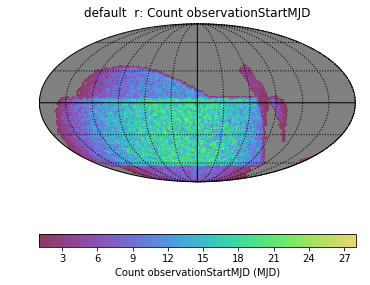

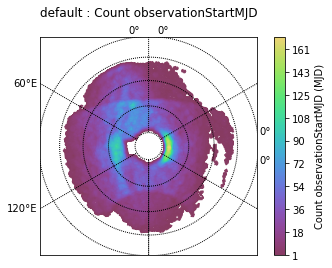

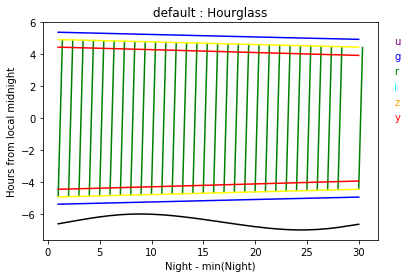

In [6]:
#start with the default weights, just r-band
runName = 'default'
weights = {'m5_weight': 3,
          'count_uniformity_weight' : 0.3,
           'slewtime_weight': 3., 'filter_change_weight': 3.}
filters = ['r']
run_sim(runName, weights, filters)


In [ ]:
#Now to ephasize slewtime
runName = 'HeavySlew'
weights = {'m5_weight': 3,
          'count_uniformity_weight' : 0.3,
           'slewtime_weight': 10., 'filter_change_weight': 3.}
filters = ['r']
run_sim(runName, weights, filters)


In [ ]:
#Now to ephasize m5
runName = 'HeavyM5'
weights = {'m5_weight': 30,
          'count_uniformity_weight' : 0.3,
           'slewtime_weight': 3., 'filter_change_weight': 3.}
filters = ['r']

run_sim(runName, weights, filters)

In [ ]:
#Finally, we want a very uniform survey
runName = 'HeavyUniform'
weights = {'m5_weight': 3,
          'count_uniformity_weight' : 5,
           'slewtime_weight': 3., 'filter_change_weight': 3.}
filters = ['r']

run_sim(runName, weights, filters)